In [42]:
import xarray as xr
import numpy as np
import pandas as pd
# import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
# xroms is an augmented xarray to work with ROMS outputs
import xroms
# cmocean colormaps for oceanography. xcmocean for auto choice of colormap
# import cmocean.cm as cmo
# import xcmocean 

In [24]:
url = "https://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/files/doppio_avg_20240201_0000_0001.nc"
# url = "https://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/runs/Averages_RUN_2024-02-01T00:00:00Z"
ds = xr.open_dataset(url)
# ds.cf.describe()
ds

<xarray.Dataset>
Dimensions:         (tracer: 2, boundary: 4, s_rho: 40, s_w: 41, eta_rho: 106, xi_rho: 242, eta_u: 106, xi_u: 241, eta_v: 105, xi_v: 242, eta_psi: 105, xi_psi: 241, ocean_time: 1)
Coordinates:
  * s_rho           (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
  * s_w             (s_w) float64 -1.0 -0.975 -0.95 -0.925 ... -0.05 -0.025 0.0
    lon_rho         (eta_rho, xi_rho) float64 ...
    lat_rho         (eta_rho, xi_rho) float64 ...
    lon_u           (eta_u, xi_u) float64 ...
    lat_u           (eta_u, xi_u) float64 ...
    lon_v           (eta_v, xi_v) float64 ...
    lat_v           (eta_v, xi_v) float64 ...
    lon_psi         (eta_psi, xi_psi) float64 ...
    lat_psi         (eta_psi, xi_psi) float64 ...
  * ocean_time      (ocean_time) datetime64[ns] 2024-02-01T12:00:00
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/107)
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          datetime64[ns] ...
    shuffle         int32 ...
    ...              ...
    salt            (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    shflux          (ocean_time, eta_rho, xi_rho) float64 ...
    ssflux          (ocean_time, eta_rho, xi_rho) float64 ...
    swrad_daily     (ocean_time, eta_rho, xi_rho) float64 ...
    sustr           (ocean_time, eta_u, xi_u) float64 ...
    svstr           (ocean_time, eta_v, xi_v) float64 ...
Attributes: (12/35)
    file:                            doppio_avg_6605_0001.nc
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS nonlinear model averages file
    title:                           DOPPIO
    var_info:                        ../Data/varinfo1040t_daily.dat
    ...                              ...
    compiler_flags:                  -fp-model precise -heap-arrays -ip -O3 -...
    tiling:                          004x004
    history:                         ROMS/TOMS, Version 3.9, Sunday - Februar...
    ana_file:                        ROMS/Functionals/ana_btflux.h
    CPP_options:                     DOPPIO, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time

In [40]:
# ds.salt.cf.sel(Z=0, method="nearest")

## Station 3 values
my_lon1=-74.2044
my_lat1=39.1833
ds1 = abs(ds.lat_rho-my_lat1)+abs(ds.lon_rho-my_lon1)
a,b = np.unravel_index(ds1.argmin(),ds1.shape)
ds2=ds.sel(eta_rho=a, xi_rho=b)

## Calculate depth (Because ROMS is gridded it does not have real life lat, lon and depth. Here we have to transform the "depth" coordinate from doppio to real world depth)

if ds2.Vtransform == 1:
        Zo_rho = ds2.hc * (ds2.s_rho - ds2.Cs_r) + ds2.Cs_r * ds2.h
        z_rho = Zo_rho + ds2.zeta * (1 + Zo_rho/ds2.h)
elif ds2.Vtransform == 2:
        Zo_rho = (ds2.hc * ds2.s_rho + ds2.Cs_r * ds2.h) / (ds2.hc + ds2.h)
        z_rho = ds2.zeta + (ds2.zeta + ds2.h) * Zo_rho

ds2.coords['z_rho'] = z_rho.transpose()
## now we can call z_rho as our depth coordinate in meters


##VALUES TO SAVE
ds2.temp[:,0]
ds2.temp[:, 39]
ds2.salt[:,0]
ds2.salt[:,39]

<xarray.DataArray 'salt' (ocean_time: 1)>
array([30.534157])
Coordinates:
    s_rho       float64 -0.0125
    lon_rho     float64 -74.2
    lat_rho     float64 39.2
  * ocean_time  (ocean_time) datetime64[ns] 2024-02-01T12:00:00
    z_rho       (ocean_time) float64 -0.2041
Attributes:
    long_name:    time-averaged salinity
    time:         ocean_time
    grid:         grid
    location:     face
    field:        salinity, scalar, series
    _ChunkSizes:  [  1  20  53 121]

In [45]:
# Load your Excel file
points_df = pd.read_excel("/Users/henrysun_1/Desktop/Duke/2024-2025/Summer 2024/fishics/data/q2a_sites.xlsx")  # Replace "points.xlsx" with the path to your Excel file

# Ensure your Excel file has columns named 'Lat', 'Lon', and 'Station'
points = points_df.to_dict(orient='records')

# Initialize an empty list to store the results
data = []

# Loop through each point
for point in points:
    my_lon = point["Lon"]
    my_lat = point["Lat"]
    station = point["Station"]
    
    # Find the nearest grid point
    ds1 = abs(ds.lat_rho - my_lat) + abs(ds.lon_rho - my_lon)
    a, b = np.unravel_index(ds1.argmin(), ds1.shape)
    ds2 = ds.sel(eta_rho=a, xi_rho=b)
    
    # Extract the required values
    surface_temp = ds2.temp[:, 0].values[0] 
    bottom_temp = ds2.temp[:, 39].values[0] 
    surface_salt = ds2.salt[:, 0].values[0] 
    bottom_salt = ds2.salt[:, 39].values[0]
    
    # Calculate stratification
    temp_stratification = np.abs(bottom_temp - surface_temp)
    salinity_stratification = np.abs(bottom_salt - surface_salt)
    
    # Append the values to the data list
    data.append([my_lon, my_lat, station, surface_temp, bottom_temp, surface_salt, bottom_salt, temp_stratification, salinity_stratification])

df = pd.DataFrame(data, columns=["Longitude", "Latitude", "Station", "Surface_Temp", "Bottom_Temp", "Surface_Salinity", "Bottom_Salinity", "Temp_Stratification", "Salinity_Stratification"])
df

,Longitude,Latitude,Station,Surface_Temp,Bottom_Temp,Surface_Salinity,Bottom_Salinity,Temp_Stratification,Salinity_Stratification
0,-74.204407,39.183304,3,6.173378,6.425122,30.602028,30.534157,0.251743,0.067871
1,-74.207153,39.104489,5,6.502448,6.757258,31.001396,30.926825,0.254810,0.074571
2,-74.092545,39.272988,6,6.486210,6.684779,30.936914,30.905615,0.198569,0.031299
3,-74.050598,39.325799,7,6.705602,6.853973,31.138642,31.111870,0.148371,0.026773
4,-74.130249,39.215231,8,6.298375,6.571083,30.751474,30.706996,0.272708,0.044478
5,-74.053345,39.217359,10,6.765540,6.998834,31.222072,31.161187,0.233293,0.060886
6,-74.440613,39.217359,11,5.595084,5.843881,29.834941,29.799025,0.248797,0.035916
7,-74.286804,39.404367,14,6.063083,5.979533,29.841456,29.730255,0.083550,0.111201
8,-74.130249,39.550648,15,6.050690,6.223523,29.768774,29.579372,0.172833,0.189401
9,-74.004084,39.472230,16,6.502612,6.737354,30.925408,30.571376,0.234742,0.354032


# Random forest model

In [57]:
## Joining eDNA-oceanographic dataset

data = pd.read_csv("/Users/henrysun_1/Desktop/Duke/2024-2025/Summer 2024/fishics/data/data_for_henry_2024.csv")
data = data[data['date'] == '2/1/24']
# data
df = df.rename(columns={"Station": "station", "Temp_Stratification": "temp_strat", "Salinity_Stratification" : 'salt_strat'})
merged_df = data.merge(df, on='station', how='inner')
# merged_df
fish_asvs = merged_df.iloc[:,11:86]
# fish_asvs
ml_df = merged_df.iloc[:,11:] # type: ignore
ml_df

,Atl_croaker_(nibea98),Bay_anchovy,Black_drum_or_Spot,Black_sea_bass,Brd_striped_anchovy,Little_tunny_or_skipjack_tuna,Nor_sea_robin,Scup,Smallmouth_flounder,Southern_kingfish(nibea95),...,White_catfish,Atl_salmon,Longitude,Latitude,Surface_Temp,Bottom_Temp,Surface_Salinity,Bottom_Salinity,temp_strat,salt_strat
0,0.000000,0.240067,0.008431,0.000000,0.000000,0.0,0.005233,0.002279,0.006085,0.003435,...,0.0,0.0,-74.204407,39.183304,6.173378,6.425122,30.602028,30.534157,0.251743,0.067871
1,0.000000,0.010920,0.000726,0.000065,0.000000,0.0,0.000610,0.000182,0.031328,0.000000,...,0.0,0.0,-74.207153,39.104489,6.502448,6.757258,31.001396,30.926825,0.254810,0.074571
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.028369,0.000000,0.000000,0.000000,...,0.0,0.0,-74.092545,39.272988,6.486210,6.684779,30.936914,30.905615,0.198569,0.031299
3,0.000000,0.075304,0.000000,0.000000,0.000000,0.0,0.000000,0.016420,0.017985,0.000000,...,0.0,0.0,-74.050598,39.325799,6.705602,6.853973,31.138642,31.111870,0.148371,0.026773
4,0.000000,0.158802,0.000000,0.000000,0.000000,0.0,0.044081,0.014342,0.000000,0.000000,...,0.0,0.0,-74.130249,39.215231,6.298375,6.571083,30.751474,30.706996,0.272708,0.044478
5,0.000000,0.013282,0.025096,0.000000,0.000000,0.0,0.008265,0.000000,0.015334,0.004269,...,0.0,0.0,-74.053345,39.217359,6.765540,6.998834,31.222072,31.161187,0.233293,0.060886
6,0.000000,0.008921,0.006158,0.000000,0.000000,0.0,0.018742,0.000000,0.036051,0.000000,...,0.0,0.0,-74.440613,39.217359,5.595084,5.843881,29.834941,29.799025,0.248797,0.035916
7,0.015507,0.038603,0.004211,0.000465,0.000000,0.0,0.001601,0.000000,0.036010,0.000402,...,0.0,0.0,-74.286804,39.404367,6.063083,5.979533,29.841456,29.730255,0.083550,0.111201
8,0.006269,0.051945,0.006176,0.000364,0.000000,0.0,0.000168,0.000000,0.033119,0.000000,...,0.0,0.0,-74.130249,39.550648,6.050690,6.223523,29.768774,29.579372,0.172833,0.189401
9,0.008507,0.069150,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.047961,0.000000,...,0.0,0.0,-74.004084,39.472230,6.502612,6.737354,30.925408,30.571376,0.234742,0.354032


In [69]:

from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import numpy as np

## MULTI OUTPUT CLASSIFIER
import warnings
warnings.filterwarnings("ignore")

# features = ml_df[['Surface_Temp','Bottom_Temp','Surface_Salinity','Bottom_Salinity','temp_strat','salt_strat']]

## temp only 
# features = ml_df[['Surface_Temp']]
## salt only
features = ml_df[['Surface_Salinity','Bottom_Salinity','salt_strat']]


labels = ml_df.loc[:, 'Atl_croaker_(nibea98)':'Atl_salmon'].applymap(lambda x: 1 if x > 0 else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
## DOES BETTER ON 30% test than 20! CTD model was better with 20

# Initialize and train the multi-output Random Forest classifier
rf_classifier = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

accuracies = []
precisions = []
recalls = []
f1_scores = []
for i, species in enumerate(labels.columns):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    # precision = precision_score(y_test.iloc[:, i], y_pred[:, i])
    # recall = recall_score(y_test.iloc[:, i], y_pred[:, i])
    # f1 = f1_score(y_test.iloc[:, i], y_pred[:, i])
    
    accuracies.append(accuracy)

    print(f"Classification report for {species}:\n", classification_report(y_test.iloc[:, i], y_pred[:, i]))
    # print(f"Accuracy for {species}: {accuracy}")

# Calculate overall average accuracy across all species
average_accuracy = np.mean(accuracies)
average_accuracy

# # Evaluate the model
# for i, species in enumerate(labels.columns):
#     print(f"Classification report for {species}:\n", classification_report(y_test.iloc[:, i], y_pred[:, i]))


Classification report for Atl_croaker_(nibea98):
               precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.50      0.50      0.50         2

    accuracy                           0.71         7
   macro avg       0.65      0.65      0.65         7
weighted avg       0.71      0.71      0.71         7

Classification report for Bay_anchovy:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.71      0.83         7

    accuracy                           0.71         7
   macro avg       0.50      0.36      0.42         7
weighted avg       1.00      0.71      0.83         7

Classification report for Black_drum_or_Spot:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      0.33      0.44         6

    accuracy                           0.29  

0.84

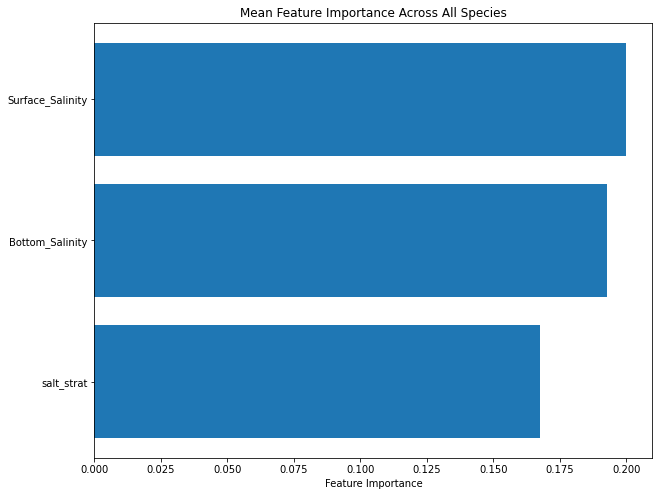

In [70]:
#Calculate feature importance
import matplotlib.pyplot as plt 

feature_importance_df = pd.DataFrame() # type: ignore
for i, species in enumerate(labels.columns):
    importances = rf_classifier.estimators_[i].feature_importances_
    feature_importance_df[species] = importances

# Calculate mean feature importance across all species
feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(features.columns, feature_importance_df['mean_importance'])
plt.xlabel('Feature Importance')
plt.title('Mean Feature Importance Across All Species')
plt.gca().invert_yaxis()
plt.show()


### Rare species model

Defining rare species calculation as any species which showed up in <20% of stations

In [91]:
threshold = len(ml_df) * 0.2

# Count the non-zero occurrences of each species
species_columns = ml_df.columns[:-10]  # Adjust the slice to exclude non-species columns if needed
species_counts = (ml_df[species_columns] > 0).sum()
filtered_species = species_counts[species_counts >= threshold].index
filtered_df = ml_df[filtered_species]
non_species_columns = df.columns[-10:]  # Adjust this if the non-species columns are at the end
filtered_df = pd.concat([filtered_df, df[non_species_columns]], axis=1)
filtered_df

,Bay_anchovy,Black_drum_or_Spot,Black_sea_bass,Nor_sea_robin,Scup,Smallmouth_flounder,Southern_kingfish(nibea95),Summ_flounder,Summ_flounder99a,Weakfish_Cyn,...,Atl_herring,Longitude,Latitude,station,Surface_Temp,Bottom_Temp,Surface_Salinity,Bottom_Salinity,temp_strat,salt_strat
0,0.240067,0.008431,0.000000,0.005233,0.002279,0.006085,0.003435,0.007596,0.002026,0.000000,...,0.007672,-74.204407,39.183304,3,6.173378,6.425122,30.602028,30.534157,0.251743,0.067871
1,0.010920,0.000726,0.000065,0.000610,0.000182,0.031328,0.000000,0.189518,0.000000,0.000246,...,0.000117,-74.207153,39.104489,5,6.502448,6.757258,31.001396,30.926825,0.254810,0.074571
2,0.000000,0.000000,0.000000,0.028369,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-74.092545,39.272988,6,6.486210,6.684779,30.936914,30.905615,0.198569,0.031299
3,0.075304,0.000000,0.000000,0.000000,0.016420,0.017985,0.000000,0.071174,0.000000,0.000000,...,0.000000,-74.050598,39.325799,7,6.705602,6.853973,31.138642,31.111870,0.148371,0.026773
4,0.158802,0.000000,0.000000,0.044081,0.014342,0.000000,0.000000,0.000000,0.000000,0.076465,...,0.000000,-74.130249,39.215231,8,6.298375,6.571083,30.751474,30.706996,0.272708,0.044478
5,0.013282,0.025096,0.000000,0.008265,0.000000,0.015334,0.004269,0.052507,0.000000,0.000000,...,0.000000,-74.053345,39.217359,10,6.765540,6.998834,31.222072,31.161187,0.233293,0.060886
6,0.008921,0.006158,0.000000,0.018742,0.000000,0.036051,0.000000,0.006414,0.011289,0.000000,...,0.000000,-74.440613,39.217359,11,5.595084,5.843881,29.834941,29.799025,0.248797,0.035916
7,0.038603,0.004211,0.000465,0.001601,0.000000,0.036010,0.000402,0.036016,0.023762,0.000883,...,0.007544,-74.286804,39.404367,14,6.063083,5.979533,29.841456,29.730255,0.083550,0.111201
8,0.051945,0.006176,0.000364,0.000168,0.000000,0.033119,0.000000,0.039519,0.011988,0.091734,...,0.005989,-74.130249,39.550648,15,6.050690,6.223523,29.768774,29.579372,0.172833,0.189401
9,0.069150,0.000000,0.000000,0.000000,0.000000,0.047961,0.000000,0.046789,0.010279,0.010791,...,0.008084,-74.004084,39.472230,16,6.502612,6.737354,30.925408,30.571376,0.234742,0.354032


In [92]:
features = filtered_df[['Surface_Salinity','Bottom_Salinity','salt_strat', 'Surface_Temp','Bottom_Temp','temp_strat']]

# must update this line after updating threshold
labels = filtered_df.loc[:, 'Bay_anchovy':'Atl_herring'].applymap(lambda x: 1 if x > 0 else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
## DOES BETTER ON 30% test than 20! CTD model was better with 20

# Initialize and train the multi-output Random Forest classifier
rf_classifier = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

accuracies = []
precisions = []
recalls = []
f1_scores = []
for i, species in enumerate(labels.columns):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    # precision = precision_score(y_test.iloc[:, i], y_pred[:, i])
    # recall = recall_score(y_test.iloc[:, i], y_pred[:, i])
    # f1 = f1_score(y_test.iloc[:, i], y_pred[:, i])
    
    accuracies.append(accuracy)

    print(f"Classification report for {species}:\n", classification_report(y_test.iloc[:, i], y_pred[:, i]))
    # print(f"Accuracy for {species}: {accuracy}")

# Calculate overall average accuracy across all species
average_accuracy = np.mean(accuracies)
average_accuracy

# # Evaluate the model
# for i, species in enumerate(labels.columns):
#     print(f"Classification report for {species}:\n", classification_report(y_test.iloc[:, i], y_pred[:, i]))


Classification report for Bay_anchovy:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.71      0.83         7

    accuracy                           0.71         7
   macro avg       0.50      0.36      0.42         7
weighted avg       1.00      0.71      0.83         7

Classification report for Black_drum_or_Spot:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      0.33      0.44         6

    accuracy                           0.29         7
   macro avg       0.33      0.17      0.22         7
weighted avg       0.57      0.29      0.38         7

Classification report for Black_sea_bass:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.50      0.33      0.40         3

    accuracy                           0.57         

0.6825396825396827

### Migratory species model

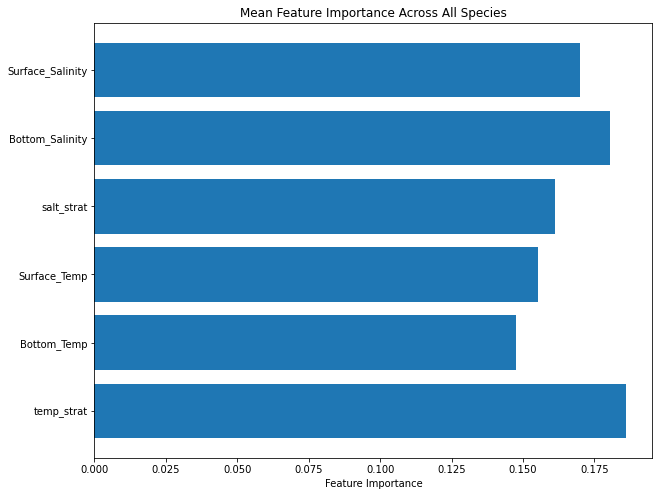

In [93]:

feature_importance_df = pd.DataFrame() # type: ignore
for i, species in enumerate(labels.columns):
    importances = rf_classifier.estimators_[i].feature_importances_
    feature_importance_df[species] = importances

# Calculate mean feature importance across all species
feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(features.columns, feature_importance_df['mean_importance'])
plt.xlabel('Feature Importance')
plt.title('Mean Feature Importance Across All Species')
plt.gca().invert_yaxis()
plt.show()

## Below: trying stratification calculation / depth

In [ ]:
import pandas as pd

## Initialize dataframe with lat/long
df = pd.read_excel('/Users/henrysun_1/Desktop/Duke/2024-2025/Summer 2024/fishics/data/q2a_sites.xlsx') 
# njsites.xls found in demo folder - modify to my own data (select points)

df.rename(columns={"Unnamed: 0":"objectID","Unnamed: 1":"Lon","Unnamed: 2":"Lat", "Unnamed: 3":"Station"},inplace=True) # Change the column names to Lon/Lat
df = df.iloc[1:]
df.round(4)
df.round({"Lon":4, "Lat":4})
Lon = df.Lon
Lat = df.Lat

df

In [8]:
## This is where I would use xarray to select the dates you would like so you can subset the data. 
## the variable name is ocean_time and you can even slice the time using something like this: https://docs.xarray.dev/en/v2023.09.0/user-guide/indexing.html (xr.sel)
## Then you can loop through the points to calculate depth in meters, pull out stratification (stratification is the gradient in temperature in a water column profile divided by the gradient in depth (or dT/dz)
## basically just change in temp/change in depth) and temperature for each location:
## REMEMBER TO CHANGE DS IN ALLPNTS FROM DS TO WHATEVER YOU RENAME YOUR TIME SLICED DATASET
# ds = ds.sel(ocean_time = '2024-02-01', method = 'nearest')
temp_final=[]
dtdz_final = []
salt_final=[]

for k in range(21): # we setup our loop here and use k as a placeholder for iterating through our however many points

    Allpnts = abs(ds.lat_rho-Lat[k])+abs(ds.lon_rho-Lon[k]) # I've taken Lat/Lon from the dataframe and put them in your equations, then use k to tell the equation which version of k to use
    a,b = np.unravel_index(Allpnts.argmin(),Allpnts.shape)
    Allpnts=ds.sel(eta_rho=a, xi_rho=b)
    
    if Allpnts.Vtransform == 1:
        Zo_rho = Allpnts.hc * (Allpnts.s_rho - Allpnts.Cs_r) + Allpnts.Cs_r * Allpnts.h
        z_rho = Zo_rho + Allpnts.zeta * (1 + Zo_rho/Allpnts.h)
    elif Allpnts.Vtransform == 2:
        Zo_rho = (Allpnts.hc * Allpnts.s_rho + Allpnts.Cs_r * Allpnts.h) / (Allpnts.hc + Allpnts.h)
        z_rho = Allpnts.zeta + (Allpnts.zeta + Allpnts.h) * Zo_rho
   
    
    Allpnts.coords['z_rho'] = z_rho.transpose()
   
    temp = Allpnts.temp
    salt = Allpnts.salt
        
    temp_diff = np.diff(temp)/np.diff(np.abs(z_rho)) # Need to take the maximum of this to get max(dT/dz)
    # salt_diff=np.diff(salt)/np.diff(z_rho)
    
    tempdtdz1=np.max(-1*temp_diff, axis=1)
    # saltdtdz1=np.max(-1.*salt_diff, axis=1)

    #bottom_temp = temp[:,0]
    
    # plt.plot(tm,temp[:,39])
    # plt.plot(tm,bottom_temp)

# I did it!
    data_xr = xr.DataArray(tempdtdz1, 
    coords={'ocean_time': ds.ocean_time}, 
    dims=['ocean_time'])
    
    
    temp_final.append(temp) #this is an example of how you create a new xarray object, note that above I initialized temp_final as an empty array, and below I use the xarray concat function OUTSIDE of the loop... I don't know why this is how it works :) 
    # bottom_temp_final.append(bottom_temp)
    salt_final.append(salt)
    dtdz_final.append(data_xr)

KeyError: 0

In [ ]:
## Now you can call this xarray object for temperature to plot temperature at a specific point. You may not want this one, but it should work the same with the other variables
combined_tempdtdz = xr.concat(dtdz_final,dim='k')
combined_temp=xr.concat(temp_final,dim='k')
combined_salt=xr.concat(salt_final,dim='k')
## now you can call combined_tempdtdz etc to make plots and look at data! or take averages over a time period. 
## These should have z_rho in their coordinates for the depth but let me know if that isn't true. 